In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import io, os, sys, types
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv("bike_demand_train.csv")
train.shape

(11116440, 8)

In [3]:
train.head(3)

,rent_place_num,rent_time,holder,rent_freq,bef_1,bef_2,bef_3,bef_4
0,101,2017-06-01 00,5,2.0,2.0,2.0,1.0,2.0
1,101,2017-06-01 01,5,0.0,2.0,2.0,2.0,1.0
2,101,2017-06-01 02,5,0.0,0.0,2.0,2.0,2.0


In [4]:
test = pd.read_csv("bike_demand_test.csv")
test.shape

(914400, 8)

In [5]:
test.head(3)

,rent_place_num,rent_time,holder,rent_freq,bef_1,bef_2,bef_3,bef_4
0,101,2018-06-01 00,5,1.0,2.0,7.0,3.0,1.0
1,101,2018-06-01 01,5,3.0,1.0,2.0,7.0,3.0
2,101,2018-06-01 02,5,2.0,3.0,1.0,2.0,7.0


In [ ]:
train.info()

In [ ]:
test.info()

In [6]:
## 불필요 columns drop
def drop_columns(feature,x):
    x.drop(feature, axis = 1, inplace=True)

In [7]:
drop_columns(["rent_time","rent_place_num"],train)
drop_columns(["rent_time","rent_place_num"],test)

In [8]:
print(train.shape)
print(test.shape)

(11116440, 6)
(914400, 6)


In [9]:
## 하이퍼파라미터 튜닝
tf.set_random_seed(777)

In [48]:
learning_rate= 0.001
total_epoch = 4
batch_size = 128

In [11]:
n_input = 6 # Number of features 
n_step = 4  # Stride 
n_hidden = 32
n_class = 1

In [ ]:
## Data scaler
def MinMaxScaler(data):
    # 데이터 모든숫자들을 최소 값만큼 뺀다.
    numerator = data - np.min(data, 0)
    # 최대값과 최소 값의 차이(A)를 구한다
    denominator = np.max(data, 0) - np.min(data, 0)
    # 너무 큰 값이 나오지 않도록 나눈다
    return numerator / (denominator + 1e-7)

In [12]:
#train = MinMaxScaler(train)
x_pd = train
y_pd = train.loc[:,["rent_freq"]]
#test = MinMaxScaler(test)
tx_pd = test
ty_pd = test.loc[:,["rent_freq"]]

In [13]:
X_train= x_pd.as_matrix()
y_train= y_pd.as_matrix().reshape([len(train),n_class])
X_test= tx_pd.as_matrix()
y_test= ty_pd.as_matrix().reshape([len(test),n_class])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
## Build train dataset
dataX = []
dataY = []
for i in range(0, len(y_pd)- n_step):
    _x = X_train[i: i + n_step]
    _y = y_train[i + n_step]
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)


[[5. 2. 2. 2. 1. 2.]
 [5. 0. 2. 2. 2. 1.]
 [5. 0. 0. 2. 2. 2.]
 [5. 1. 0. 0. 2. 2.]] -> [0.]


In [15]:
## Build test data set 
dataXt = []
dataYt = []
for i in range(0, len(ty_pd)- n_step):
    _xt = X_test[i: i + n_step]
    _yt = y_test[i + n_step]
    if i is 0:
        print(_xt, "->", _yt)
    dataXt.append(_xt)
    dataYt.append(_yt)

[[5. 1. 2. 7. 3. 1.]
 [5. 3. 1. 2. 7. 3.]
 [5. 2. 3. 1. 2. 7.]
 [5. 1. 2. 3. 1. 2.]] -> [0.]


In [16]:
train_size= int(len(dataY) * 1.0)
test_size = int(len(dataYt)* 1.0)

trainX, testX =np.array(dataX[0:train_size]), np.array(dataXt[0:test_size])
trainY, testY =np.array(dataY[0:train_size]), np.array(dataYt[0:test_size])

In [17]:
X = tf.placeholder(tf.float32, [None,n_step,n_input])
print("X", X)
Y = tf.placeholder(tf.float32, [None,n_class])
print("Y", Y)

X Tensor("Placeholder:0", shape=(?, 4, 6), dtype=float32)
Y Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [18]:
targets = tf.placeholder(tf.float32,[None,n_class])
predictions = tf.placeholder(tf.float32,[None,n_class])

In [19]:
## lstm cell 생성
def lstm_cell():
    # LSTM셀을 생성한다.
    # num_units: 각 Cell 출력 크기
    # forget_bias: The bias added to forget gates.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.sigmoid)
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=0.8, state_is_tuple=True, activation=tf.tanh)
    return cell

In [20]:
## 1 cell layer 모델
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)], state_is_tuple=True)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [21]:
## lstm output
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 4, 32), dtype=float32)


In [22]:
Y_pred = tf.contrib.layers.fully_connected(hypothesis[:, -1], n_class, activation_fn=None)

In [23]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [ ]:
#is_correct = tf.equal(Y_pred,Y, dtype=tf.float32)
#accuracy = tf.reduce_mean(tf.cast(is_correct))

In [24]:
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [35]:
np.shape(trainY)

(11116436, 1)

In [46]:
len(y_train)

11116440

In [26]:
##모델 학습 및 테스트
period = int(X_train.shape[0]/batch_size)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
iEpoch = []
iavgCost = []

In [47]:
for epoch in range(1,total_epoch+1):
        total_cost = 0
        #generator=batch_generator(batch_size,n_step,n_input) ##<<2nd batch selecting method
        for i in range(period) :
            idx = np.random.choice((len(y_train) -4), batch_size)

            x_batch = trainX[idx]
            y_batch = trainY[idx]
                       
            #batch_xs, batch_ys =next(generator)  ##<<2nd batch selecting method
                #batch_xs, batch_ys =next_batch(batch_size)
                
            #_, cost_val = sess.run([train, loss], feed_dict={X: batch_xs, Y: batch_ys})
            _, cost_val = sess.run([train, loss], feed_dict={X: x_batch, Y: y_batch})
            total_cost += cost_val

        print('Epoch:', '%04d' % (epoch + 1),
              'Avg cost =', '{:.5f}'.format(total_cost / period))
            
        iEpoch.append(epoch)
        iavgCost.append(total_cost / period)
            
test_predict = sess.run(Y_pred, feed_dict={X: testX})
rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
print("rmse: ", rmse_val)

Epoch: 0002 Avg cost = 325.23986


In [50]:
for epoch in range(1,total_epoch+1):
        total_cost = 0
        #generator=batch_generator(batch_size,n_step,n_input) ##<<2nd batch selecting method
        for i in range(period):
            idx = np.random.choice((len(y_train)-4), batch_size)
            x_batch = trainX[idx]
            y_batch = trainY[idx]
                       
            #batch_xs, batch_ys =next(generator)  ##<<2nd batch selecting method
                #batch_xs, batch_ys =next_batch(batch_size)  
            #_, cost_val = sess.run([train, loss], feed_dict={X: batch_xs, Y: batch_ys})
            
            _, cost_val = sess.run([train, loss], feed_dict={X: x_batch, Y: y_batch})
            total_cost += cost_val

        print('Epoch:', '%04d' % (epoch + 1),
              'Avg cost =', '{:.5f}'.format(total_cost / period))
            
        iEpoch.append(epoch)
        iavgCost.append(total_cost /period)

Epoch: 0002 Avg cost = 162.52563
Epoch: 0003 Avg cost = 161.01936
Epoch: 0004 Avg cost = 162.81080
Epoch: 0005 Avg cost = 161.08473


In [ ]:
type(iEpoch)

rmse:  1.7483288


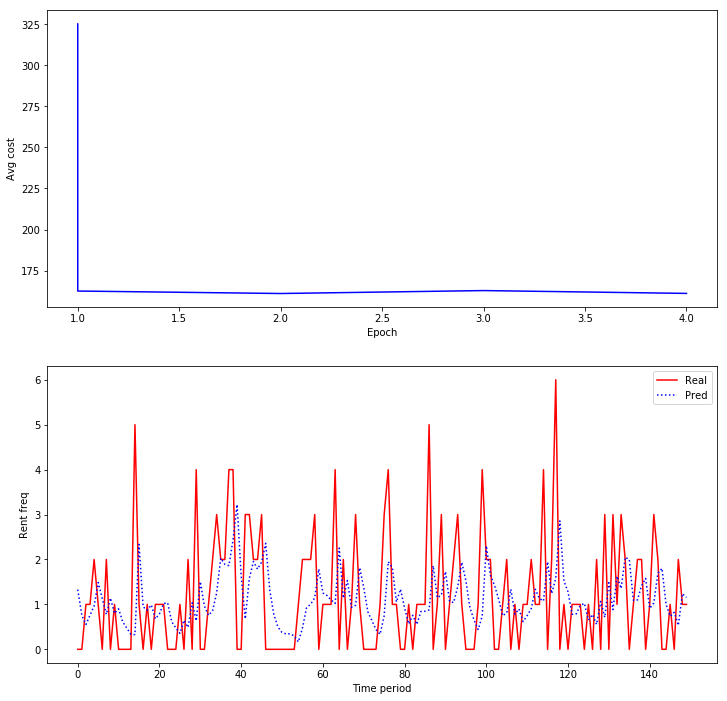

In [51]:
test_predict = sess.run(Y_pred, feed_dict={X: testX})
np.savetxt('lstm_demand_addtime.csv', test_predict, delimiter=',', fmt='%f')    
# 테스트용 데이터 기준으로 측정지표 rmse를 산출한다
rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
print("rmse: ", rmse_val)
    
    
fig = plt.figure()
fig.set_size_inches(12,12)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(iEpoch, iavgCost, 'b')
ax2.plot(testY[:150], 'r',label= 'Real')
ax2.plot(test_predict[:150], 'b:',label='Pred')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg cost")

ax2.set_xlabel("Time period")
ax2.set_ylabel("Rent freq")
ax2.legend()
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12,12)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(iEpoch, iavgCost, 'b')
ax2.plot(testY[0:200], 'r',label= 'Real')
ax2.plot(test_predict[4:204], 'b:',label='Pred')
ax2.plot(abs(testY[0:200] - test_predict[4:204])*5, 'k',label='Difference')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg cost")

ax2.set_xlabel("Time period")
ax2.set_ylabel("Rent freq")
ax2.legend()
plt.show()